In [1]:
import nltk
import re

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay, auc, roc_curve)

In [12]:
classification = ['obj_key', 'completion_percentage', 'date_end_task_month',
              'diff_end_task_end_bpo', 'n_workers', 'sub_prg_target_count', 'sub_prg_target_mean',
              'obj_prg_target_count', 'podr_target_count', 'gen_target_std', 'target']

regression = ['obj_key', 'date_end_task_month', 'date_end_bpo_month',
                  'diff_end_task_end_bpo', 'sub_prg_target_count', 'sub_prg_target_mean',
                  'sub_prg_target_std', 'podr_target_count', 'podr_target_mean',
                  'podr_target_std', 'target']

In [13]:
data = pd.read_csv('class_dataset.csv')
# [col for col in data.columns if col not in classification]
data = data.drop(columns=['date_start_task', 'date_end_task', 'date_start_bpo', 'date_end_bpo', 'date_report'])
data.info()

C:\Users\ykolt\AppData\Local\Temp\ipykernel_17620\1114240729.py:1: DtypeWarning: Columns (11,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('class_dataset.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772916 entries, 0 to 772915
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   obj_prg                    772916 non-null  object 
 1   obj_subprg                 772916 non-null  object 
 2   obj_key                    772916 non-null  object 
 3   task_key                   772916 non-null  object 
 4   task_name                  772916 non-null  object 
 5   completion_percentage      772916 non-null  float64
 6   examination_status         772916 non-null  float64
 7   examination                772916 non-null  object 
 8   target                     772916 non-null  int64  
 9   date_start_task_month      772916 non-null  int64  
 10  date_start_task_season     772916 non-null  int64  
 11  date_end_task_month        772916 non-null  int64  
 12  date_end_task_season       772916 non-null  int64  
 13  date_start_bpo_month       63

In [14]:
data['target'].value_counts()

target
0    688545
1     84371
Name: count, dtype: int64

In [15]:
#data_test = data.sort_values(by='date_report')[data['date_report']=='2023-05-29']

In [16]:
features_train, features_test, target_train, target_test = train_test_split(data.drop(columns=['target']),
                                                                                data['target'],
                                                                                test_size=0.25,
                                                                                random_state=12345)
display(features_train.shape)
features_train[list(features_train.select_dtypes('object').columns)] = features_train[list(features_train.select_dtypes('object').columns)].fillna('Пропущенное значение')
features_test[list(features_test.select_dtypes('object').columns)] = features_test[list(features_test.select_dtypes('object').columns)].fillna('Пропущенное значение')

(579687, 44)

In [17]:
target_train.value_counts()

target
0    516542
1     63145
Name: count, dtype: int64

### Классификация объектов, чтобы посмотреть, стоит ли нами предсказывать день или нет 

In [19]:
#mae = make_scorer(mean_absolute_error)

model = CatBoostClassifier(verbose=False, cat_features = list(
            features_train
            .select_dtypes(include=['object'])
            .columns
        ),)

parameters = {
    'learning_rate': [i/1000 for i in range(2, 8, 2)],
    'depth': [4, 6, 8],
     'loss_function': ['Logloss'],
      'task_type': ['GPU']
}


grid = GridSearchCV(estimator = model, param_grid = parameters,  cv=3, verbose=3)
#grid.fit(features_train, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END depth=4, learning_rate=0.002, loss_function=Logloss, task_type=GPU;, score=0.897 total time=  28.3s
[CV 2/3] END depth=4, learning_rate=0.002, loss_function=Logloss, task_type=GPU;, score=0.898 total time=  27.5s
[CV 3/3] END depth=4, learning_rate=0.002, loss_function=Logloss, task_type=GPU;, score=0.898 total time=  27.6s
[CV 1/3] END depth=4, learning_rate=0.004, loss_function=Logloss, task_type=GPU;, score=0.904 total time=  27.9s
[CV 2/3] END depth=4, learning_rate=0.004, loss_function=Logloss, task_type=GPU;, score=0.905 total time=  28.0s
[CV 3/3] END depth=4, learning_rate=0.004, loss_function=Logloss, task_type=GPU;, score=0.904 total time=  29.0s
[CV 1/3] END depth=4, learning_rate=0.006, loss_function=Logloss, task_type=GPU;, score=0.908 total time=  28.2s
[CV 2/3] END depth=4, learning_rate=0.006, loss_function=Logloss, task_type=GPU;, score=0.910 total time=  28.0s
[CV 3/3] END depth=4, learning_rate=

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002B742D001F0>,
             param_grid={'depth': [4, 6, 8],
                         'learning_rate': [0.002, 0.004, 0.006],
                         'loss_function': ['Logloss'], 'task_type': ['GPU']},
             verbose=3)

In [20]:
print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best params:  {'depth': 8, 'learning_rate': 0.006, 'loss_function': 'Logloss', 'task_type': 'GPU'}
Best score:  0.9338022070531166


In [21]:
model = CatBoostClassifier(task_type='GPU', cat_features = list(
            features_train
            .select_dtypes(include=['object'])
            .columns
        ),
        learning_rate = 0.006,
        depth = 8,
        iterations = 5000,
        random_state = 12345,
        loss_function ='Logloss',
        eval_metric='F1')

model.fit(features_train, target_train)

0:	learn: 0.3699433	total: 87.1ms	remaining: 7m 15s
1:	learn: 0.3742539	total: 169ms	remaining: 7m 1s
2:	learn: 0.3376911	total: 239ms	remaining: 6m 37s
3:	learn: 0.3302512	total: 306ms	remaining: 6m 21s
4:	learn: 0.2844156	total: 395ms	remaining: 6m 34s
5:	learn: 0.2838029	total: 472ms	remaining: 6m 33s
6:	learn: 0.2876537	total: 544ms	remaining: 6m 28s
7:	learn: 0.3110526	total: 613ms	remaining: 6m 22s
8:	learn: 0.3103370	total: 692ms	remaining: 6m 23s
9:	learn: 0.2920915	total: 766ms	remaining: 6m 22s
10:	learn: 0.2850841	total: 845ms	remaining: 6m 23s
11:	learn: 0.2840505	total: 922ms	remaining: 6m 23s
12:	learn: 0.2838209	total: 1.01s	remaining: 6m 27s
13:	learn: 0.2749029	total: 1.09s	remaining: 6m 29s
14:	learn: 0.2896013	total: 1.17s	remaining: 6m 27s
15:	learn: 0.2955095	total: 1.24s	remaining: 6m 25s
16:	learn: 0.2936945	total: 1.31s	remaining: 6m 23s
17:	learn: 0.2934632	total: 1.38s	remaining: 6m 23s
18:	learn: 0.2955380	total: 1.46s	remaining: 6m 22s
19:	learn: 0.2970826	t

In [22]:
predictions = model.predict_proba(features_test)
print(roc_auc_score(target_test, predictions[:,1]))

0.9856420481971581


In [24]:
predictions = model.predict_proba(features_test)[:,1]
precision, recall, thresholds = precision_recall_curve(target_test, predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.9051077922353358


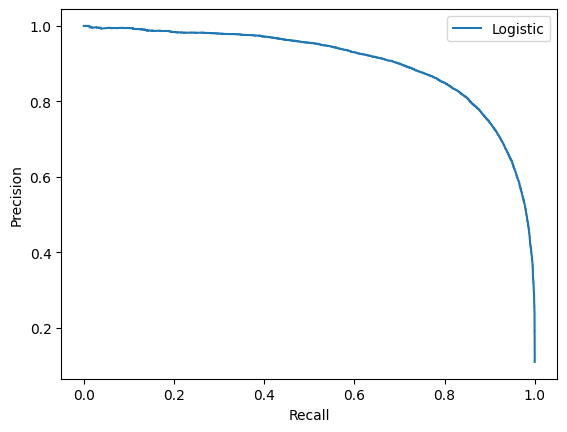

In [25]:
def plot_roc_curve(test_y, model_probs):
    # plot model roc curve
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


def plot_pr_curve(test_y, model_probs):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

predictions = model.predict_proba(features_test)[:,1]
plot_pr_curve(target_test, predictions)

In [26]:
model.save_model('catboost_class.bin')

### Регрессия

In [2]:
try:
    del data
except:
    pass

In [3]:
# ['date_start_task', 'date_end_task', 'date_start_bpo', 'date_end_bpo', 'date_report']
data = pd.read_csv('dataset.csv')
data = data.drop(columns=['date_start_task', 'date_end_task', 'date_start_bpo', 'date_end_bpo', 'date_report'])
data.info()

data = data[data['target'] != 0]

features_train, features_test, target_train, target_test = train_test_split(data.drop(columns=['target']),
                                                                                data['target'],
                                                                                test_size=0.25,
                                                                                random_state=12345)
display(features_train.shape)

features_train[list(features_train.select_dtypes('object').columns)] = features_train[list(features_train.select_dtypes('object').columns)].fillna('Пропущенное значение')
features_test[list(features_test.select_dtypes('object').columns)] = features_test[list(features_test.select_dtypes('object').columns)].fillna('Пропущенное значение')

C:\Users\ykolt\AppData\Local\Temp\ipykernel_19944\1931158387.py:2: DtypeWarning: Columns (11,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772916 entries, 0 to 772915
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   obj_prg                    772916 non-null  object 
 1   obj_subprg                 772916 non-null  object 
 2   obj_key                    772916 non-null  object 
 3   task_key                   772916 non-null  object 
 4   task_name                  772916 non-null  object 
 5   completion_percentage      772916 non-null  float64
 6   examination_status         772916 non-null  float64
 7   examination                772916 non-null  object 
 8   target                     772916 non-null  int64  
 9   date_start_task_month      772916 non-null  int64  
 10  date_start_task_season     772916 non-null  int64  
 11  date_end_task_month        772916 non-null  int64  
 12  date_end_task_season       772916 non-null  int64  
 13  date_start_bpo_month       63

(63278, 44)

In [ ]:
mae = make_scorer(mean_absolute_error, greater_is_better=False)

model = CatBoostRegressor(verbose=False, cat_features = list(
            features_train
            .select_dtypes(include=['object'])
            .columns
        ),)

parameters = {
    'learning_rate': [i/1000 for i in range(2, 8, 2)],
    'depth': [4, 6, 8],
     'loss_function': ['RMSE'],
      'task_type': ['GPU']
}


grid = GridSearchCV(estimator = model, param_grid = parameters, scoring=mae, cv=3, verbose=3)
grid.fit(features_train, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END depth=4, learning_rate=0.002, loss_function=RMSE, task_type=GPU;, score=-11.824 total time=  24.7s
[CV 2/3] END depth=4, learning_rate=0.002, loss_function=RMSE, task_type=GPU;, score=-11.795 total time=  25.9s
[CV 3/3] END depth=4, learning_rate=0.002, loss_function=RMSE, task_type=GPU;, score=-11.860 total time=  25.1s
[CV 1/3] END depth=4, learning_rate=0.004, loss_function=RMSE, task_type=GPU;, score=-11.086 total time=  24.6s
[CV 2/3] END depth=4, learning_rate=0.004, loss_function=RMSE, task_type=GPU;, score=-11.024 total time=  25.5s
[CV 3/3] END depth=4, learning_rate=0.004, loss_function=RMSE, task_type=GPU;, score=-11.052 total time=  25.7s
[CV 1/3] END depth=4, learning_rate=0.006, loss_function=RMSE, task_type=GPU;, score=-10.625 total time=  30.0s
[CV 2/3] END depth=4, learning_rate=0.006, loss_function=RMSE, task_type=GPU;, score=-10.537 total time=  30.7s
[CV 3/3] END depth=4, learning_rate=0.006, l

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002B760957FD0>,
             param_grid={'depth': [4, 6, 8],
                         'learning_rate': [0.002, 0.004, 0.006],
                         'loss_function': ['RMSE'], 'task_type': ['GPU']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=3)

In [34]:
print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best params:  {'depth': 8, 'learning_rate': 0.006, 'loss_function': 'RMSE', 'task_type': 'GPU'}
Best score:  -8.285205273367481


In [4]:
model = CatBoostRegressor(task_type='GPU', cat_features = list(
            features_train
            .select_dtypes(include=['object'])
            .columns
        ),
        iterations = 8000,
        random_state = 12345,
        depth = 8,
        # loss_function ='RMSE',
        learning_rate = 0.05)

model.fit(features_train, target_train)

0:	learn: 18.9785495	total: 35.9ms	remaining: 4m 47s
1:	learn: 18.7303026	total: 71.2ms	remaining: 4m 44s
2:	learn: 18.5343580	total: 117ms	remaining: 5m 11s
3:	learn: 18.2625660	total: 152ms	remaining: 5m 3s
4:	learn: 18.0898999	total: 183ms	remaining: 4m 52s
5:	learn: 17.8916859	total: 220ms	remaining: 4m 52s
6:	learn: 17.7242701	total: 259ms	remaining: 4m 56s
7:	learn: 17.5303965	total: 305ms	remaining: 5m 5s
8:	learn: 17.3638541	total: 353ms	remaining: 5m 13s
9:	learn: 17.2113785	total: 399ms	remaining: 5m 19s
10:	learn: 17.0661706	total: 455ms	remaining: 5m 30s
11:	learn: 16.9006950	total: 523ms	remaining: 5m 47s
12:	learn: 16.7779905	total: 557ms	remaining: 5m 41s
13:	learn: 16.6579968	total: 593ms	remaining: 5m 38s
14:	learn: 16.5489379	total: 627ms	remaining: 5m 33s
15:	learn: 16.4229859	total: 664ms	remaining: 5m 31s
16:	learn: 16.3247701	total: 707ms	remaining: 5m 32s
17:	learn: 16.2359860	total: 749ms	remaining: 5m 32s
18:	learn: 16.0992131	total: 787ms	remaining: 5m 30s
19:

In [5]:
print(mean_absolute_error(target_test,model.predict(features_test)))

3.7878352852167447


In [6]:
model.save_model('catboost_regress.bin')

## Делаем пайплайн решения

In [7]:
data = pd.read_csv('dataset.csv')
data = data.drop(columns=['date_start_task', 'date_end_task', 'date_start_bpo', 'date_end_bpo', 'date_report'])
data.info()

features_train, features_test, target_train, target_test = train_test_split(data.drop(columns=['target']),
                                                                                data['target'],
                                                                                test_size=0.25,
                                                                                random_state=12345)
display(features_train.shape)

features_train[list(features_train.select_dtypes('object').columns)] = features_train[list(features_train.select_dtypes('object').columns)].fillna('Пропущенное значение')
features_test[list(features_test.select_dtypes('object').columns)] = features_test[list(features_test.select_dtypes('object').columns)].fillna('Пропущенное значение')

C:\Users\ykolt\AppData\Local\Temp\ipykernel_19944\3786503500.py:1: DtypeWarning: Columns (11,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772916 entries, 0 to 772915
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   obj_prg                    772916 non-null  object 
 1   obj_subprg                 772916 non-null  object 
 2   obj_key                    772916 non-null  object 
 3   task_key                   772916 non-null  object 
 4   task_name                  772916 non-null  object 
 5   completion_percentage      772916 non-null  float64
 6   examination_status         772916 non-null  float64
 7   examination                772916 non-null  object 
 8   target                     772916 non-null  int64  
 9   date_start_task_month      772916 non-null  int64  
 10  date_start_task_season     772916 non-null  int64  
 11  date_end_task_month        772916 non-null  int64  
 12  date_end_task_season       772916 non-null  int64  
 13  date_start_bpo_month       63

(579687, 44)

In [8]:
def pipline (features_test):
    # Модель регрессии
    model_regres = CatBoostRegressor()
    model_regres.load_model('catboost_regress.bin')

    # Модель классификации
    model_class  = CatBoostClassifier()
    model_class.load_model('catboost_class.bin')

    pred = model_class.predict(features_test)

    for i in tqdm(range(len(pred))):
        if pred[i] == 1:
            pred[i] = model_regres.predict(features_test.iloc[i])

    return pred

print(mean_absolute_error(target_test, pipline(features_test)))

100%|██████████| 193229/193229 [02:24<00:00, 1333.92it/s]


0.8303360261658447


1.0482795025591396
